In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)


In [2]:
dataset = pd.read_csv('/content/Mastercard_stock_price.csv',index_col='Date', parse_dates=["Date"])

In [3]:
dataset.shape

(3872, 7)

In [4]:
dataset.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000,0.0,0.0
2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000,0.0,0.0
2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000,0.0,0.0
2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000,0.0,0.0
2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000,0.0,0.0


In [5]:
dataset.tail(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-10-05,347.121403,348.130138,342.497241,342.776886,4724100,0.00,0.0
2021-10-06,339.580960,348.439763,338.682072,348.250000,3712000,0.00,0.0
2021-10-07,349.000000,357.899994,349.000000,353.910004,3209200,0.44,0.0
2021-10-08,356.000000,360.369995,354.209991,354.959991,2336700,0.00,0.0
2021-10-11,353.950012,354.880005,346.899994,347.149994,2766800,0.00,0.0


In [6]:
dataset.drop(['Dividends','Stock Splits'],axis=1,inplace=True)

In [7]:
dataset.tail(5)

,Open,High,Low,Close,Volume
Date,,,,,
2021-10-05,347.121403,348.130138,342.497241,342.776886,4724100
2021-10-06,339.580960,348.439763,338.682072,348.250000,3712000
2021-10-07,349.000000,357.899994,349.000000,353.910004,3209200
2021-10-08,356.000000,360.369995,354.209991,354.959991,2336700
2021-10-11,353.950012,354.880005,346.899994,347.149994,2766800


In [8]:
dataset.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0


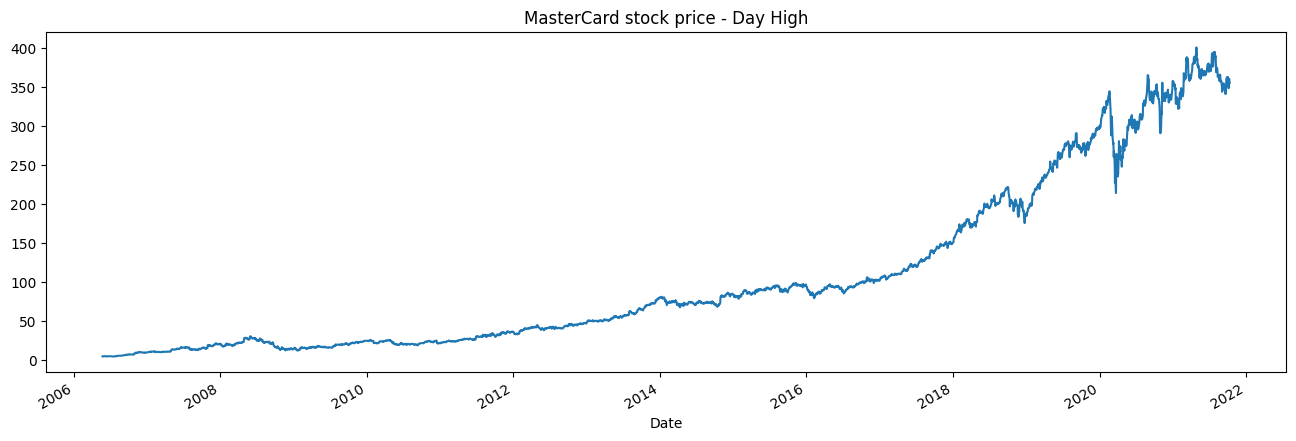

In [9]:
dataset['High'].plot(figsize=(16, 5))
plt.title("MasterCard stock price - Day High")
plt.show()

In [10]:
tstart = 2016
tend = 2020

def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"]
    test = dataset.loc[f"{tend+1}":, "High"]
    return train, test
training_set, test_set = train_test_split(dataset, tstart, tend)

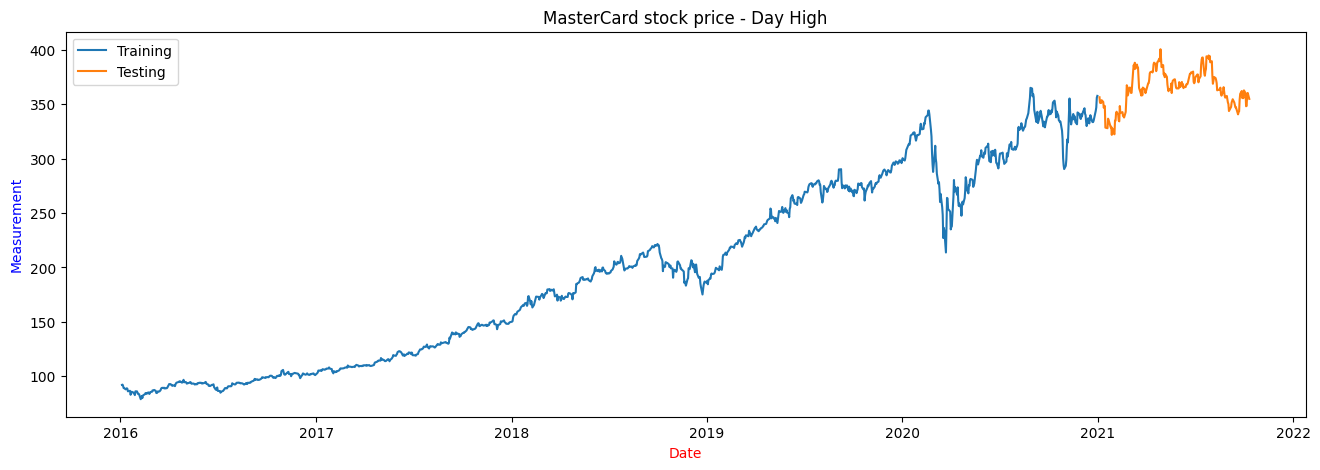

In [11]:
plt.figure(figsize=(16, 5))
plt.plot(training_set)
plt.plot(test_set)
plt.title('MasterCard stock price - Day High')
plt.ylabel('Measurement', color='blue')
plt.xlabel('Date', color='red')
plt.legend(['Training', 'Testing'])
plt.show()

In [12]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.values.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [13]:
def split_sequence(sequence, n_steps,forecasting_horizon):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - forecasting_horizon:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:end_ix+forecasting_horizon]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 50
forecasting_horizon = 7
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps,forecasting_horizon)

In [14]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

In [15]:
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_train shape: (1203, 50, 1)
y_train shape: (1203, 7, 1)


**RNN TRAINING**

In [16]:
# The LSTM architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=100, activation="tanh", input_shape=(n_steps, features)))
model_lstm.add(Dense(units=forecasting_horizon))
# Compiling the model
model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           707 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,507 (162.14 KB)

 Trainable params: 41,507 (162.14 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model_lstm.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0572
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0060
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0037
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0028
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0023
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0020
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0018
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0017
Epoch 9/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0015
Epoch 10/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0014
Epoch 11/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0014
Epoch 12/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0015
Epoch 13/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0013
Epoch 14/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0012
Epoch 15/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - lo

In [18]:
#scaling
inputs = test_set.values.reshape(-1, 1)
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps,forecasting_horizon)

# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)

print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_test shape: (139, 50, 1)
y_test shape: (139, 7, 1)


In [19]:
#prediction
predicted_stock_price = model_lstm.predict(X_test)

#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
print('predicted_stock_price shape: ', predicted_stock_price.shape)

#inverse transform the test labels.
y_test = y_test.reshape(y_test.shape[0], y_test.shape[1])
y_test = sc.inverse_transform(y_test)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
predicted_stock_price shape:  (139, 7)


In [20]:
def return_mae(test, predicted):
    mae = mean_absolute_error(test, predicted)
    print("Mean Absolute Error {:.2f}.".format(mae))

for i in range(forecasting_horizon):
  print("Forecasting Horizon: {} ".format(i))
  return_mae(y_test[:,i],predicted_stock_price[:,i])
  print("")

Forecasting Horizon: 0 
Mean Absolute Error 13.15.

Forecasting Horizon: 1 
Mean Absolute Error 16.79.

Forecasting Horizon: 2 
Mean Absolute Error 16.21.

Forecasting Horizon: 3 
Mean Absolute Error 18.52.

Forecasting Horizon: 4 
Mean Absolute Error 19.86.

Forecasting Horizon: 5 
Mean Absolute Error 16.77.

Forecasting Horizon: 6 
Mean Absolute Error 17.84.



In [21]:
X_test = X_test.reshape(-1, 50)
X_test = sc.inverse_transform(X_test)

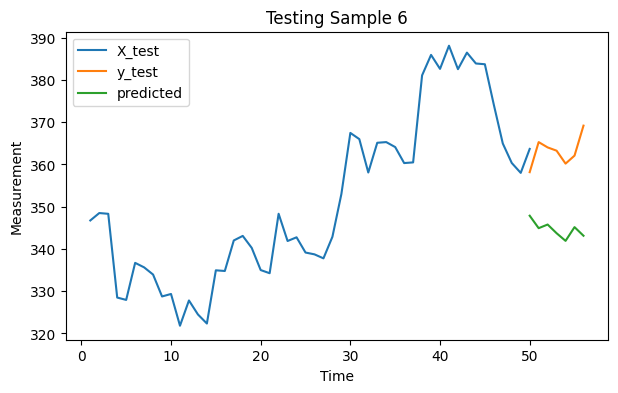

In [22]:
sample_index = 6
plt.figure(figsize=(7, 4))
plt.plot(np.arange(1, n_steps+1, 1),X_test[sample_index,:])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),y_test[sample_index,:])
plt.plot(np.arange(n_steps, n_steps+forecasting_horizon, 1),predicted_stock_price[sample_index,:])
plt.title('Testing Sample ' + str(sample_index))
plt.ylabel('Measurement')
plt.xlabel('Time')
plt.legend(['X_test', 'y_test', 'predicted'], loc='upper left')

In [23]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("MasterCard Stock Price Prediction")
    plt.xlabel("Days Ahead")
    plt.ylabel("MasterCard Stock Price")
    plt.legend()
    plt.show()

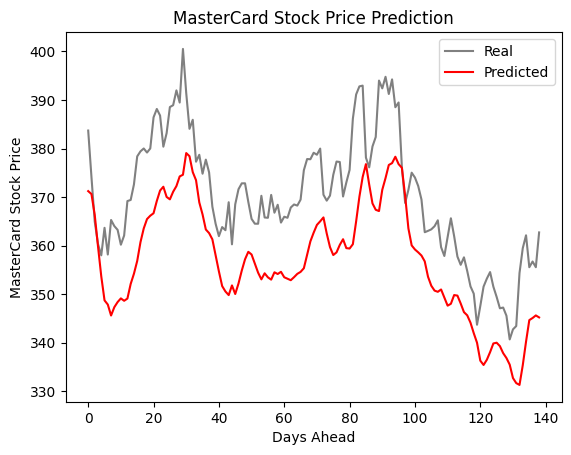

In [24]:
#Here we visualize the real vs. predicted values for one day forecasting horizon.
plot_predictions(y_test[:,0],predicted_stock_price[:,0])